In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = 'is_fraud'

# Separate features and target
X = train.drop(columns=[target])
y = train[target]

print(train.head())
print(train.info())

# Check target variable distribution
print(train['is_fraud'].value_counts(normalize=True))

# Keep 'id' for test set
test_ids = test['id']

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop                          job  \
0  ...  62220  38.5127  -89.9847    

In [3]:
from sklearn.impute import SimpleImputer


def preprocess_data(df, drop_cols):
    # Convert date/time if available
    if 'trans_date' in df.columns and 'trans_time' in df.columns:
        df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'], errors='coerce')
        df['hour'] = df['trans_datetime'].dt.hour
        df['day_of_week'] = df['trans_datetime'].dt.dayofweek
        df['day'] = df['trans_datetime'].dt.day
        df.drop(['trans_datetime', 'trans_date', 'trans_time'], axis=1, inplace=True, errors='ignore')

    # Don't drop lat/long columns here if you need them for haversine_distance
    # Remove only columns you are sure you won't need
    safe_drop = [c for c in drop_cols if c not in ['lat','long','merch_lat','merch_long']]
    df.drop(columns=safe_drop, inplace=True, errors='ignore')

    # Separate numeric and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Impute numeric columns
    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Impute categorical columns
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # Fill any remaining NaN
    df.fillna(-999, inplace=True)

    return df


# List of columns to drop
'''
drop_cols = ['id', 'trans_num', 'unix_time', 'first', 'last', 'street', 'city', 'state', 
             'zip', 'job', 'dob', 'lat', 'long', 'merch_lat', 'merch_long']
             '''

drop_cols = [
    'id', 'trans_num', 'unix_time', 'cc_num', 'first', 'last', 
    'street', 'city', 'state', 'job', 'dob', 
    # Notice we do NOT drop 'merchant', 'zip', 'category', 'lat', 'long', 'merch_lat', 'merch_long' here
    # since we need them for feature engineering
]

# Preprocess training and test sets
X = preprocess_data(X, drop_cols)

test = preprocess_data(test, drop_cols)


# Handle categorical features consistently
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], test[col]], axis=0).astype(str)  # Combine for consistent encoding
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


def process_datetime_features(df):
    # If trans_date and trans_time are given as strings
    # Combine them into a single datetime column if needed
    if 'trans_date' in df.columns and 'trans_time' in df.columns:
        df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
        df['hour'] = df['trans_datetime'].dt.hour
        df['day_of_week'] = df['trans_datetime'].dt.dayofweek
        df['day'] = df['trans_datetime'].dt.day
        df.drop(['trans_datetime','trans_date','trans_time'], axis=1, inplace=True, errors='ignore')
    return df

X = process_datetime_features(X)
test = process_datetime_features(test)
'''
# 2. Drop columns that may not be predictive or are unique identifiers
drop_cols = ['id', 'trans_num', 'unix_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 
             'merchant', 'lat', 'long', 'merch_lat', 'merch_long']
for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
    if col in test.columns:
        test.drop(col, axis=1, inplace=True)
'''

# 3. Handle categorical features
# Identify categorical columns (object type)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Earth radius in km
    r = 6371  
    return c * r


def feature_engineering(df):
    # Log-transform transaction amount
    if 'amt' in df.columns:
        df['amt_log'] = np.log1p(df['amt'])
        # Bin transaction amounts
        df['amt_bin'] = pd.cut(df['amt'], bins=[0, 50, 100, 500, 1000, 5000, np.inf], labels=False, include_lowest=True)

    # Hour-Category interaction
    if 'hour' in df.columns and 'category' in df.columns:
        df['hour_category'] = df['hour'].astype(str) + '_' + df['category'].astype(str)

    # Peak hour flag
    if 'hour' in df.columns:
        df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 20 else 0)

    # High transaction amount flag
    if 'amt' in df.columns:
        df['is_high_amt'] = (df['amt'] > 5000).astype(int)

    df['hour_day_interaction'] = df['hour'] * df['day']

    # Compute Haversine distance if location columns are available
    if all(c in df.columns for c in ['lat','long','merch_lat','merch_long']):
        df['distance'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
        # Drop the original lat/long columns after computing distance
        df.drop(['lat','long','merch_lat','merch_long'], axis=1, inplace=True, errors='ignore')

    return df

# New function to add ratio-based features
def add_ratio_features(X_train, y_train, X_test):
    # Compute fraud ratio by zip code
    # Make sure 'zip' column exists in X_train before using this
    if 'zip' in X_train.columns:
        zip_stats = pd.DataFrame({
            'fraud_count': y_train.groupby(X_train['zip']).sum(),
            'total_count': X_train.groupby('zip').size()
        }).reset_index()
        zip_stats['fraud_ratio_zip'] = zip_stats['fraud_count'] / zip_stats['total_count']

        # Map back to train and test
        X_train = X_train.merge(zip_stats[['zip', 'fraud_ratio_zip']], on='zip', how='left')
        X_test = X_test.merge(zip_stats[['zip', 'fraud_ratio_zip']], on='zip', how='left')
        
        # Fill missing ratios for unseen zips in test with global fraud ratio
        global_fraud_ratio = y_train.mean()
        X_train['fraud_ratio_zip'].fillna(global_fraud_ratio, inplace=True)
        X_test['fraud_ratio_zip'].fillna(global_fraud_ratio, inplace=True)

    # Compute fraud ratio by category
    if 'category' in X_train.columns:
        cat_stats = pd.DataFrame({
            'fraud_count_cat': y_train.groupby(X_train['category']).sum(),
            'total_count_cat': X_train.groupby('category').size()
        }).reset_index()
        cat_stats['fraud_ratio_cat'] = cat_stats['fraud_count_cat'] / cat_stats['total_count_cat']

        # Map back to train and test
        X_train = X_train.merge(cat_stats[['category', 'fraud_ratio_cat']], on='category', how='left')
        X_test = X_test.merge(cat_stats[['category', 'fraud_ratio_cat']], on='category', how='left')

        # Fill missing ratios for unseen categories with global fraud ratio
        global_fraud_ratio = y_train.mean()
        X_train['fraud_ratio_cat'].fillna(global_fraud_ratio, inplace=True)
        X_test['fraud_ratio_cat'].fillna(global_fraud_ratio, inplace=True)

    return X_train, X_test

def add_merchant_features(X_train, y_train, X_test):
    # Compute merchant-level stats
    if 'merchant' in X_train.columns:
        # Merchant fraud ratio
        merc_stats = pd.DataFrame({
            'fraud_count_merc': y_train.groupby(X_train['merchant']).sum(),
            'total_count_merc': X_train.groupby('merchant').size()
        }).reset_index()
        merc_stats['fraud_ratio_merc'] = merc_stats['fraud_count_merc'] / merc_stats['total_count_merc']

        # Define a merchant outlier (rare merchant): 
        # For example, merchants with fewer than 10 transactions are considered rare.
        rare_threshold = 10
        merc_stats['is_merchant_rare'] = (merc_stats['total_count_merc'] < rare_threshold).astype(int)

        # Merge merchant features back into training and test sets
        X_train = X_train.merge(merc_stats[['merchant', 'fraud_ratio_merc', 'total_count_merc', 'is_merchant_rare']],
                                on='merchant', how='left')
        X_test = X_test.merge(merc_stats[['merchant', 'fraud_ratio_merc', 'total_count_merc', 'is_merchant_rare']],
                              on='merchant', how='left')

        global_fraud_ratio = y_train.mean()
        X_train['fraud_ratio_merc'].fillna(global_fraud_ratio, inplace=True)
        X_test['fraud_ratio_merc'].fillna(global_fraud_ratio, inplace=True)

        # Fill missing merchant frequency stats with some default
        X_train['total_count_merc'].fillna(0, inplace=True)
        X_test['total_count_merc'].fillna(0, inplace=True)
        X_train['is_merchant_rare'].fillna(1, inplace=True)
        X_test['is_merchant_rare'].fillna(1, inplace=True)

    return X_train, X_test


# Add ratio features
X, test = add_ratio_features(X, y, test)

# Add merchant features
# X, test = add_merchant_features(X, y, test)

# Now that merchant-based features are computed, if you want you can drop 'merchant' 
# because it's already encoded into new features. Do this before feature_engineering if desired:
if 'merchant' in X.columns:
    X.drop('merchant', axis=1, inplace=True, errors='ignore')
if 'merchant' in test.columns:
    test.drop('merchant', axis=1, inplace=True, errors='ignore')


X = feature_engineering(X)
test = feature_engineering(test)


# Handle categorical features (after all feature engineering)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Fill any remaining missing values
X.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)


/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_27710/4090723082.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['fraud_ratio_zip'].fillna(global_fraud_ratio, inplace=True)
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_27710/4090723082.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [ ]:
from sklearn.ensemble import RandomForestClassifier

importances = RandomForestClassifier().fit(X, y).feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importances)


amt_log             0.234455
amt                 0.226252
day                 0.122740
amt_bin             0.090363
hour                0.063281
fraud_ratio_zip     0.035664
fraud_ratio_cat     0.033393
is_peak_hour        0.031899
fraud_ratio_merc    0.029338
hour_category       0.027792
category            0.023381
total_count_merc    0.021437
day_of_week         0.017342
city_pop            0.011760
zip                 0.010874
distance            0.010819
gender              0.009184
is_high_amt         0.000026
is_merchant_rare    0.000000
dtype: float64


In [12]:
low_importance_features = ['is_high_amt', 'is_merchant_rare']
X = X.drop(columns=low_importance_features, errors='ignore')
test = test.drop(columns=low_importance_features, errors='ignore')

X = X.drop(columns=['amt'])
test = test.drop(columns=['amt'])

corr = X[['amt', 'amt_log']].corr()
print(corr)  # If correlation > 0.9, consider dropping one

KeyError: "['amt'] not in index"

In [5]:
from imblearn.over_sampling import SMOTE

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid with reduced ranges
param_grid_test = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
}

param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
}

# Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
# Randomized Search with fewer iterations and 3-fold CV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # Fewer iterations for speed
    scoring='f1',
    cv=3,  
    verbose=1,
    n_jobs=-1,  # Use all cores
    random_state=42
)

# Fit the RandomizedSearchCV on a smaller subset (optional)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
#random_search.fit(X_sample, y_sample)
model = random_search.fit(X_train_resampled, y_train_resampled)


# Get the best model
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Validate the model
val_preds = best_rf_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val, val_preds))


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Validation F1 Score: 0.9585433841409169


In [6]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_val)
print("F1 Score:", f1_score(y_val, y_pred))


F1 Score: 0.9687462579331817


In [7]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

param_grid = {
    'iterations': [100, 300],
    'depth': [4, 6],
    'learning_rate': [0.1, 0.2]
}



# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Convert datasets to CatBoost's Pool format for efficiency
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations
    scoring='f1',
    cv=2,
    verbose=2,
    random_state=42
)
randomized_search.fit(X_train, y_train)

# Get the best parameters and model
print("Best Parameters:", randomized_search.best_params_)
#print("Best Parameters:", best_params)

# Use the best model for predictions
best_model = randomized_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val, y_val_pred))



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.9s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   0.9s
[CV] END .........depth=4, iterations=100, learning_rate=0.2; total time=   0.8s
[CV] END .........depth=4, iterations=100, learning_rate=0.2; total time=   0.8s
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time=   4.5s
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time=   4.5s
[CV] END .........depth=4, iterations=300, learning_rate=0.2; total time=   4.4s
[CV] END .........depth=4, iterations=300, learning_rate=0.2; total time=   4.4s
[CV] END .........depth=6, iterations=100, learning_rate=0.1; total time=   1.0s
[CV] END .........depth=6, iterations=100, learning_rate=0.1; total time=   1.0s
[CV] END .........depth=6, iterations=100, learning_rate=0.2; total time=   1.0s
[CV] END .........depth=6, iterations=100, learni

Confusion Matrix:
 [[65530   151]
 [  396  8064]]


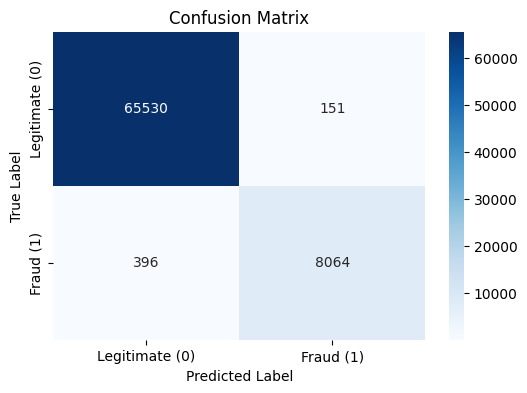

In [14]:
from sklearn.metrics import f1_score, confusion_matrix
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

# Optional: Display confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate (0)', 'Fraud (1)'],
            yticklabels=['Legitimate (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
submission = pd.DataFrame({'id': test_ids, 'is_fraud': test_preds})
submission.to_csv('my_submission.csv', index=False)
print("Submission file created: my_submission.csv")

Submission file created: my_submission.csv
